# Коллаборативная фильтрация

In [5]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [8]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [9]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [10]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [11]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [13]:
# Заведём фиктивный item_id, если юзер не покупал товары из топ-5000, 
# то присвоим товару id 999999
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float)

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [17]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(sparse_user_item,
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 3min 18s, sys: 6min 8s, total: 9min 26s
Wall time: 5min 29s


In [25]:
def get_recommendations(user, model, sparse_user_item, N=5):
  res = [id_to_itemid[rec] for rec in 
                  model.recommend(userid=userid_to_id[user], 
                                  user_items=sparse_user_item[userid_to_id[user]],
                                  N=N, 
                                  filter_already_liked_items=False, 
                                  filter_items=[itemid_to_id[999999]], 
                                  recalculate_user=True)[0]]
  return res

In [19]:
def precision_at_k(recommended_list, bought_list, k):
    
  bought_list = np.array(bought_list)
  recommended_list = np.array(recommended_list)
  
  recommended_list = recommended_list[:k]
  
  flags = np.isin(bought_list, recommended_list)
  
  precision = flags.sum() / len(recommended_list)
  
  
  return precision

In [27]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual'], k=5), axis=1).mean()

CPU times: user 3.62 s, sys: 2.6 s, total: 6.21 s
Wall time: 3.34 s


0.1811949069539667

In [28]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1105488, 1033142, 5569374, 979707, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 910032, 5569327, 1022003]"


**Embeddings**

In [29]:
model.item_factors.shape

(5001, 100)

In [30]:
model.user_factors.shape

(2499, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [31]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [34]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 

In [35]:
def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [36]:
model.item_factors.shape

(5001, 100)

In [37]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

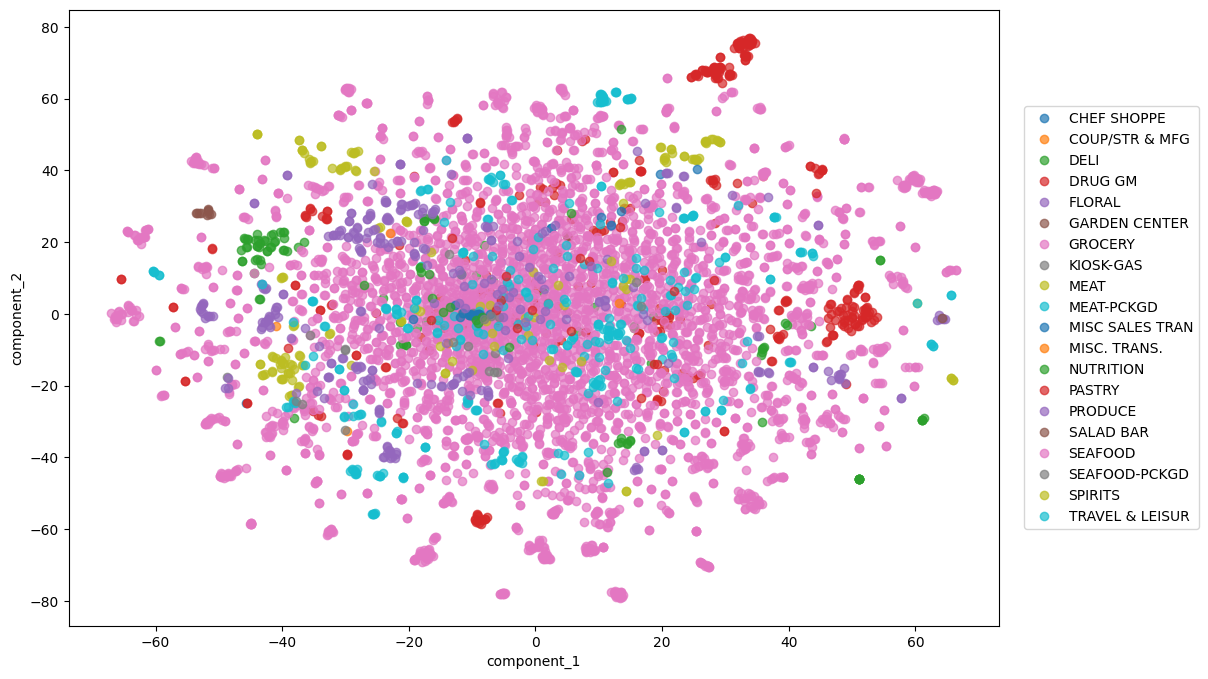

CPU times: user 1min 59s, sys: 358 ms, total: 1min 59s
Wall time: 1min 9s


In [38]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

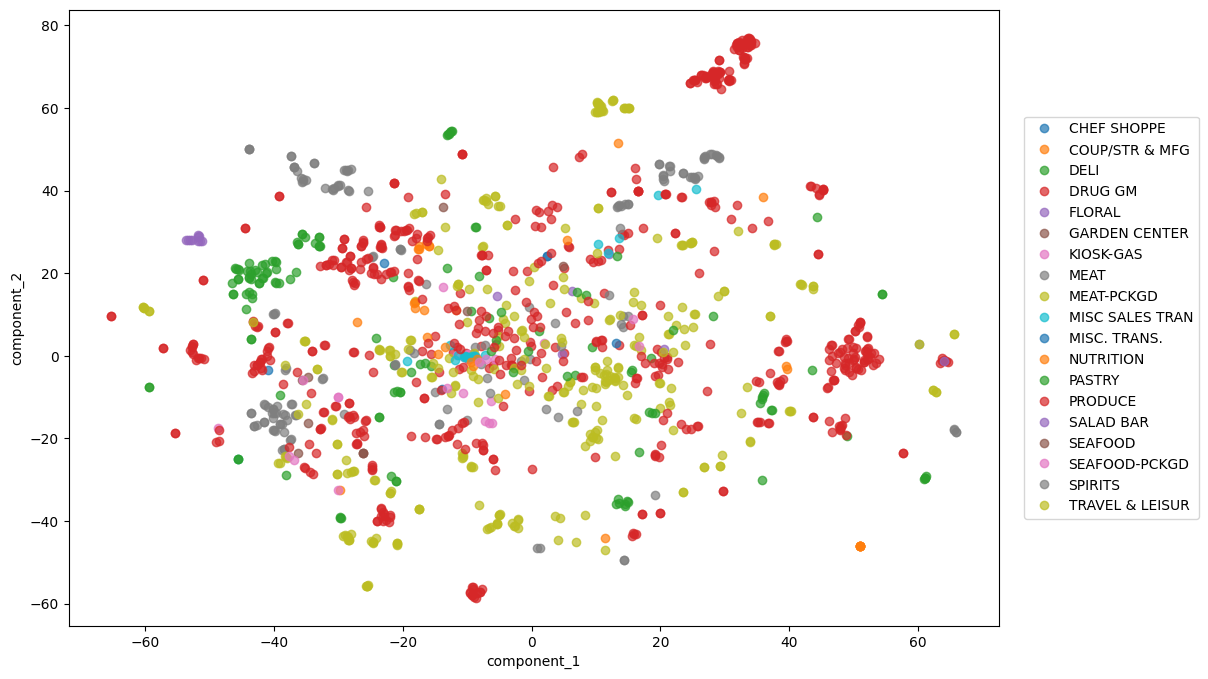

In [39]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

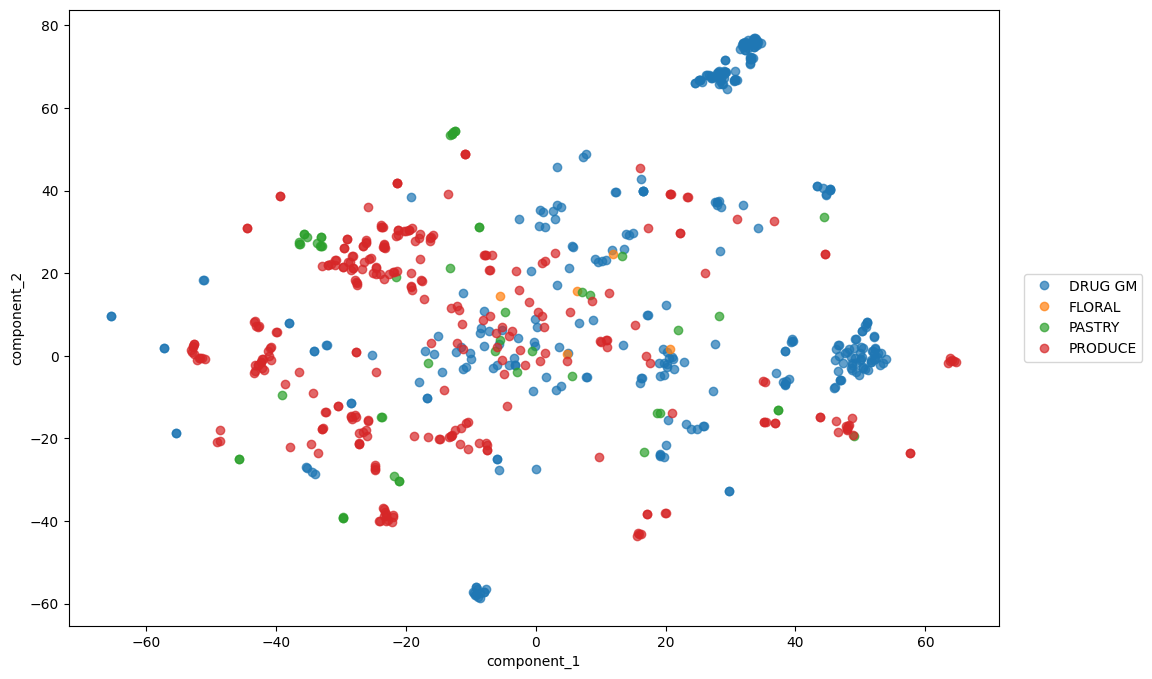

In [40]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

In [41]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item,
                                      filter_already_liked_items=True, 
                                      filter_items=[itemid_to_id[999999]], 
                                      recalculate_user=True,
                                      )

CPU times: user 2.67 s, sys: 0 ns, total: 2.67 s
Wall time: 2.55 s


In [42]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

Посмотрите также / Похожие товары

In [43]:
model.similar_items(1, N=5)

(array([   1,    2, 3932,    5, 4257], dtype=int32),
 array([1.0000001 , 0.75517845, 0.73981684, 0.73855406, 0.7273017 ],
       dtype=float32))

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [44]:
model.similar_users(userid_to_id[10], N=5)

(array([   9,  239,  354,  790, 1380], dtype=int32),
 array([1.        , 0.9754457 , 0.97391886, 0.97347695, 0.97197247],
       dtype=float32))

# TF-IDF взвешивание

In [55]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix.T).T.tocsr()

In [56]:
%%time

model = AlternatingLeastSquares(factors=200, 
                                regularization=0.01,
                                iterations=10, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,
          show_progress=True)

result['als_tfidf'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual'], k=5), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 4min 26s, sys: 7min 57s, total: 12min 24s
Wall time: 7min 14s


0.18276199804113616

# BM25 взвешивание

In [57]:
bm25_user_item_matrix = bm25_weight(user_item_matrix.T).T.tocsr()

In [58]:
%%time

model = AlternatingLeastSquares(factors=200, 
                                regularization=0.01,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),
          show_progress=True)

result['als_bm25'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual'], k=5), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 4min 30s, sys: 8min 8s, total: 12min 39s
Wall time: 7min 18s


0.2309500489715965